# DS 2500 Project: Predicting Inflation
This project's aim is to use features such as GDP, Federal funds rate, sentiment, and unemployment
to predict inflation, which is a huge economical problem currently. All data is obtained from FRED (which 
stands for Federal Reserve Economic Data. Therefore, it is definitely reliable. Since the data is macroeconomic
focused, there aren't any privacy or ethical concerns.

In [1]:
# First, get all imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer

# Data Reading in and Cleaning

In [2]:
# Define filenames
INFLATION = "cpi.csv"
FEDERAL_FUNDS = "federal_funds.csv"
GDP = "gdp.csv"
SENTIMENT = "sentiment.csv"
UNEMPLOYMENT = "unemployment.csv"

In [3]:
# Read files in
inflation_df = pd.read_csv(INFLATION)
federal_df = pd.read_csv(FEDERAL_FUNDS)
gdp_df = pd.read_csv(GDP)
sentiment_df = pd.read_csv(SENTIMENT)
unemployment_df = pd.read_csv(UNEMPLOYMENT)

In [4]:
# Convert date column in each df to datettime
dfs = [inflation_df, federal_df, gdp_df, sentiment_df, unemployment_df]

for df in dfs:
    df['DATE'] = pd.to_datetime(df['DATE'])

Now we need to apply the appropriate transformations to each individual dataset, to make sure that
daily/monthly data is converted to aggregated quarterly data, which will then be used as features
and targets. The % change in each quarter's target data will be used to predict the % change in inflation for the next quarter, since it will take a couple of months (or potentially even longer) to come into effect. 

# 1: Inflation Data
Inflation data is represented by the Consumer Price Index (CPI). This is index represents the prices of a 'basket of goods and services' over times. The change in the value of this index is the inflation % that we see so frequently in  news headlines

In [5]:
# Let's see what the inflation data looks like
inflation_df.head()

,DATE,CPILFESL
0,1957-01-01,28.5
1,1957-02-01,28.6
2,1957-03-01,28.7
3,1957-04-01,28.8
4,1957-05-01,28.8


In [6]:
# First, lets rename the CPILFESL column to CPI
inflation_df = inflation_df.rename(columns={'CPILFESL': 'CPI'})

In [7]:
# Now, we need to convert the monthly data to quarterly data. This would be better done
# using a function, in case other datasets are monthly too.

# Take the average of all months in each quarter for quarterly values
def convert_monthly_to_quarterly(df):
    df.set_index('DATE', inplace=True)
    quarterly_data = df.resample('Q').mean()
    quarterly_data.reset_index(inplace=True)
    return quarterly_data

In [8]:
# Convert inflation df to quarterly
inflation_df = convert_monthly_to_quarterly(inflation_df)
inflation_df['year_month'] = inflation_df['DATE'].dt.to_period('M')
inflation_df.head()

,DATE,CPI,year_month
0,1957-03-31,28.600000,1957-03
1,1957-06-30,28.833333,1957-06
2,1957-09-30,29.033333,1957-09
3,1957-12-31,29.266667,1957-12
4,1958-03-31,29.400000,1958-03


In [9]:
# Now, get the percentage change from one quarter to the next. These
# will be the target inflation values
inflation_df.ffill(inplace=True)
inflation_df['inflation'] = inflation_df['CPI'].pct_change() * 100
inflation_df.head()

,DATE,CPI,year_month,inflation
0,1957-03-31,28.600000,1957-03,NaN
1,1957-06-30,28.833333,1957-06,0.815851
2,1957-09-30,29.033333,1957-09,0.693642
3,1957-12-31,29.266667,1957-12,0.803674
4,1958-03-31,29.400000,1958-03,0.455581


# 2. GDP Data
GDP (gross domestic spending) refers to the sum of consumer expenditure, government expenditure, investments, 
as well as net exports in a country's economy. Theoretically, gdp is directly proportional to inflation.

In [10]:
# Let's see what the GDP data looks like
gdp_df.head()

,DATE,GDP
0,1957-01-01,469.779
1,1957-04-01,472.025
2,1957-07-01,479.490
3,1957-10-01,474.864
4,1958-01-01,467.540


In [11]:
# This data is already in quarterly format, however, quarter values correspond for the start of 
# the quarter rather than the last, which other dataframe follow. We need to transform this.
gdp_df.ffill(inplace=True)
gdp_df['DATE'] = gdp_df['DATE'].apply(lambda x: x.replace(month={4: 3, 7: 6, 10: 9}.get(x.month, x.month)))
gdp_df['year_month'] = gdp_df['DATE'].dt.to_period('M')

# calculate quarterly percentage changes in GDP
gdp_df['gdp_change'] = gdp_df['GDP'].pct_change() * 100
gdp_df.head()

,DATE,GDP,year_month,gdp_change
0,1957-01-01,469.779,1957-01,NaN
1,1957-03-01,472.025,1957-03,0.478097
2,1957-06-01,479.490,1957-06,1.581484
3,1957-09-01,474.864,1957-09,-0.964775
4,1958-01-01,467.540,1958-01,-1.542336


# 3. Federal Funds Data
The Federal Funds rate is the base interesr rate set by the Fed, with the aim of curbing inflation.
The previous quarter change in federal funds rate could be a good indicator of what current inflation
will look like.

In [12]:
# Let's see what the federal funds data looks like
federal_df.head()

,DATE,DFF
0,1957-01-01,3.0
1,1957-01-02,1.0
2,1957-01-03,3.0
3,1957-01-04,3.0
4,1957-01-05,3.0


In [13]:
# This seems to be daily data. Lets convert this to quarterly data
federal_df.ffill(inplace=True)
federal_df = convert_monthly_to_quarterly(federal_df)
federal_df['year_month'] = federal_df['DATE'].dt.to_period('M')
federal_df.head()

,DATE,DFF,year_month
0,1957-03-31,2.933000,1957-03
1,1957-06-30,3.000000,1957-06
2,1957-09-30,3.230761,1957-09
3,1957-12-31,3.252717,1957-12
4,1958-03-31,1.869778,1958-03


In [14]:
# Now convert quarterly average rates to % changes in average rates

federal_df['ff_change'] = federal_df['DFF'].pct_change() * 100
federal_df.head()

,DATE,DFF,year_month,ff_change
0,1957-03-31,2.933000,1957-03,NaN
1,1957-06-30,3.000000,1957-06,2.284350
2,1957-09-30,3.230761,1957-09,7.692029
3,1957-12-31,3.252717,1957-12,0.679608
4,1958-03-31,1.869778,1958-03,-42.516439


# Unemployment Data
Unemployment rate refers to the % of people who are in the workforce (either employed or actively looking for a job)
who don't have a job. Change in unemployment may have an affect on next months inflation

In [15]:
# Let's see what the unemployment data looks like
unemployment_df.head()

,DATE,UNRATE
0,1957-01-01,4.2
1,1957-02-01,3.9
2,1957-03-01,3.7
3,1957-04-01,3.9
4,1957-05-01,4.1


In [16]:
# This seems to have monthly values. We need to convert monthly to quarterly
unemployment_df.ffill(inplace=True)
unemployment_df = convert_monthly_to_quarterly(unemployment_df)
unemployment_df['year_month'] = unemployment_df['DATE'].dt.to_period('M')

In [17]:
# and then convert the rate to a % change in unemployment
unemployment_df['unemp_chg'] = unemployment_df['UNRATE'].pct_change() * 100
unemployment_df.head()

,DATE,UNRATE,year_month,unemp_chg
0,1957-03-31,3.933333,1957-03,NaN
1,1957-06-30,4.100000,1957-06,4.237288
2,1957-09-30,4.233333,1957-09,3.252033
3,1957-12-31,4.933333,1957-12,16.535433
4,1958-03-31,6.300000,1958-03,27.702703


# Consumer Sentiment Data
The UMich Consumer Sentiment Index is one of the longest-running economic sentiment surveys, with historical data dating back to the mid-1940s.It includes questions that gauge consumers' attitudes toward economic conditions, including their current financial situation, their expectations for the future, and their perceptions of business conditions.

The survey involves approximately 500 interviews per month, conducted by phone or online. The sample is designed to be representative of the U.S. population in terms of demographics like income, age, and geographic location. The Consumer Sentiment Index typically ranges from 0 to 100, with higher values indicating greater consumer confidence. A value above 90 is often considered indicative of a healthy economy, while values below 70 might signal economic uncertainty or recession fears. 

In [18]:
# Let's see what the unemployment data looks like
sentiment_df.head()

,DATE,UMCSENT
0,1957-05-01,92.9
1,1957-06-01,.
2,1957-07-01,.
3,1957-08-01,.
4,1957-09-01,.


In [19]:
# This df seems to have "." values scattered randomly. So, we need to account for this
# One way to do it is forward fill- assume that consumers sentiments are somewhat similar 
# to previous years sentiments
sentiment_df.replace('.', pd.NA, inplace=True)
sentiment_df.ffill(inplace=True)
sentiment_df.head()

,DATE,UMCSENT
0,1957-05-01,92.9
1,1957-06-01,92.9
2,1957-07-01,92.9
3,1957-08-01,92.9
4,1957-09-01,92.9


In [20]:
# Convert this column to floats
sentiment_df["UMCSENT"] = sentiment_df["UMCSENT"].astype(float)

# Now get monthly averages
sentiment_df = convert_monthly_to_quarterly(sentiment_df)
sentiment_df['year_month'] = sentiment_df['DATE'].dt.to_period('M')

In [21]:
# Now get percentage changes
sentiment_df['sent_chg'] = sentiment_df['UMCSENT'].pct_change() * 100
sentiment_df.head()

,DATE,UMCSENT,year_month,sent_chg
0,1957-06-30,92.900000,1957-06,NaN
1,1957-09-30,92.900000,1957-09,2.220446e-14
2,1957-12-31,86.766667,1957-12,-6.602081e+00
3,1958-03-31,80.233333,1958-03,-7.529773e+00
4,1958-06-30,80.100000,1958-06,-1.661820e-01


In [22]:
# Convert datetime column to only include month and year, not able to join because of mismatched day
# PairPlots
feature_dfs = [federal_df, gdp_df, sentiment_df, unemployment_df, inflation_df]
merged_df = feature_dfs[0]
for df in feature_dfs[1:]:
    df = df.drop(columns=['DATE'], errors='ignore')
    merged_df = pd.merge(merged_df, df, on='year_month', how='inner')
# Only keep relevant columns from merged df
features_df = merged_df[["year_month", "ff_change", "gdp_change", "sent_chg", "unemp_chg", "inflation" ]]


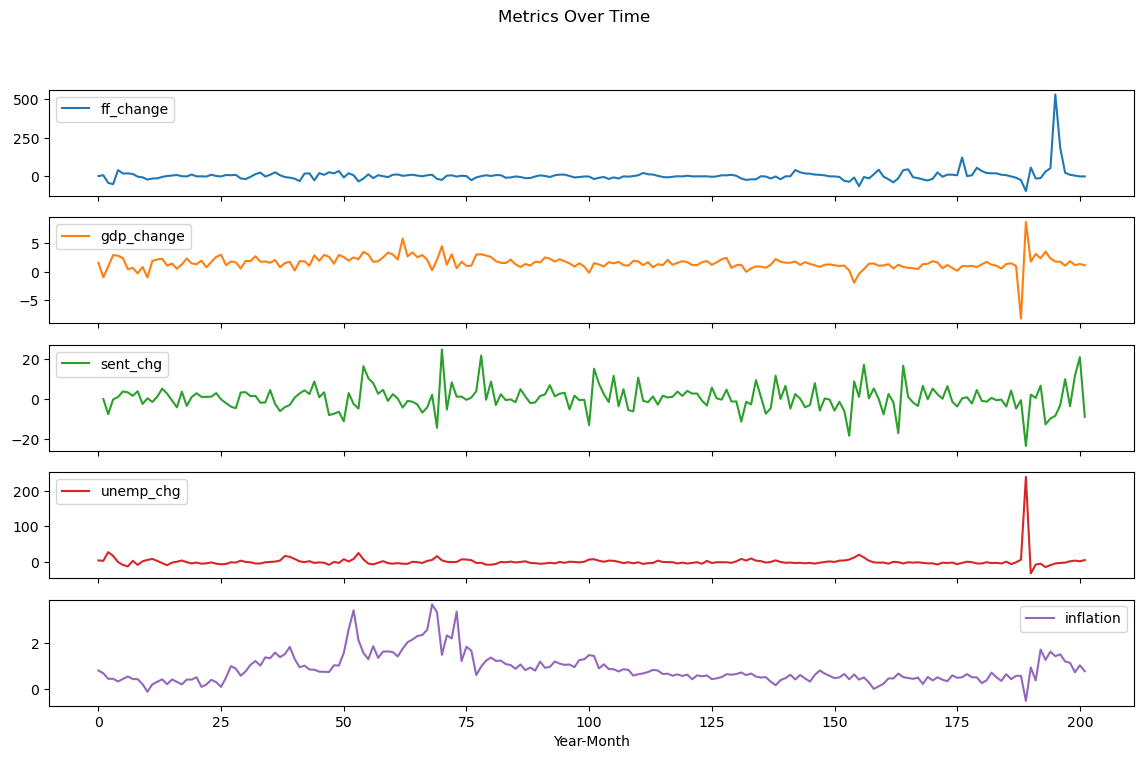

In [23]:
# Lets visualize these plots to see how each factor varies over time
features_df.plot(figsize=(14, 8), subplots=True, title="Metrics Over Time", legend=True)
plt.xlabel("Year-Month")
plt.show()

In [25]:
# By visualising these features, it seems like the covid pandemic led to several outliers, we should drop those values
start_date = '2020-01-01'
end_date = '2022-01-01'
features_df = features_df[~((features_df['year_month'] >= start_date) & (features_df['year_month'] <= end_date))]


In [26]:
# Need to generate lagged column values for some features, since they take
# time to affect inflation. Can try 1 to 4 quarter
# lags to see which predict inflation better.

# There is no need for lagged values for sentiment, since that reflects individuals'
# outlook on the current economy

lagged_columns = ["ff_change", "gdp_change", "unemp_chg"]

features_df = features_df.copy()

for col in lagged_columns:
    features_df[f"{col}_lag_1"] = features_df[col].shift(1)  # 1 quarter lag
    features_df[f"{col}_lag_2"] = features_df[col].shift(2)  # 2 quarters lag
    features_df[f"{col}_lag_3"] = features_df[col].shift(3)  # 3 quarters lag
    features_df[f"{col}_lag_4"] = features_df[col].shift(4)  # 4 quarters lag
features_df

,year_month,ff_change,gdp_change,sent_chg,unemp_chg,inflation,ff_change_lag_1,ff_change_lag_2,ff_change_lag_3,ff_change_lag_4,gdp_change_lag_1,gdp_change_lag_2,gdp_change_lag_3,gdp_change_lag_4,unemp_chg_lag_1,unemp_chg_lag_2,unemp_chg_lag_3,unemp_chg_lag_4
0,1957-06,2.284350,1.581484,NaN,4.237288,0.815851,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1957-09,7.692029,-0.964775,2.220446e-14,3.252033,0.693642,2.284350,NaN,NaN,NaN,1.581484,NaN,NaN,NaN,4.237288,NaN,NaN,NaN
2,1958-03,-42.516439,0.949224,-7.529773e+00,27.702703,0.455581,7.692029,2.284350,NaN,NaN,-0.964775,1.581484,NaN,NaN,3.252033,4.237288,NaN,NaN
3,1958-06,-49.891207,2.937213,-1.661820e-01,16.931217,0.453515,-42.516439,7.692029,2.284350,NaN,0.949224,-0.964775,1.581484,NaN,27.702703,3.252033,4.237288,NaN
4,1958-09,40.770686,2.822734,9.987516e-01,-0.452489,0.338600,-49.891207,-42.516439,7.692029,2.284350,2.937213,0.949224,-0.964775,1.581484,16.931217,27.702703,3.252033,4.237288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,2023-03,23.572375,1.065573,9.863946e+00,-1.869159,1.207348,184.676218,531.410675,52.843897,-8.558936,1.759538,1.806649,2.341021,0.994816,-2.752294,-4.385965,-8.800000,-0.917431
198,2023-06,10.489987,1.871805,-3.560372e+00,1.904762,1.149740,23.572375,184.676218,531.410675,52.843897,1.065573,1.759538,1.806649,2.341021,-1.869159,-2.752294,-4.385965,-8.800000
199,2023-09,5.435046,1.177323,1.166399e+01,3.738318,0.738809,10.489987,23.572375,184.676218,531.410675,1.871805,1.065573,1.759538,1.806649,1.904762,-1.869159,-2.752294,-4.385965
200,2024-03,0.000000,1.371730,2.079055e+01,1.785714,1.040933,5.435046,10.489987,23.572375,184.676218,1.177323,1.871805,1.065573,1.759538,3.738318,1.904762,-1.869159,-2.752294


In [27]:
# Take one more look at features_df. This df contains both feature and target columns
features_df.head()

,year_month,ff_change,gdp_change,sent_chg,unemp_chg,inflation,ff_change_lag_1,ff_change_lag_2,ff_change_lag_3,ff_change_lag_4,gdp_change_lag_1,gdp_change_lag_2,gdp_change_lag_3,gdp_change_lag_4,unemp_chg_lag_1,unemp_chg_lag_2,unemp_chg_lag_3,unemp_chg_lag_4
0,1957-06,2.284350,1.581484,NaN,4.237288,0.815851,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1957-09,7.692029,-0.964775,2.220446e-14,3.252033,0.693642,2.284350,NaN,NaN,NaN,1.581484,NaN,NaN,NaN,4.237288,NaN,NaN,NaN
2,1958-03,-42.516439,0.949224,-7.529773e+00,27.702703,0.455581,7.692029,2.284350,NaN,NaN,-0.964775,1.581484,NaN,NaN,3.252033,4.237288,NaN,NaN
3,1958-06,-49.891207,2.937213,-1.661820e-01,16.931217,0.453515,-42.516439,7.692029,2.284350,NaN,0.949224,-0.964775,1.581484,NaN,27.702703,3.252033,4.237288,NaN
4,1958-09,40.770686,2.822734,9.987516e-01,-0.452489,0.338600,-49.891207,-42.516439,7.692029,2.28435,2.937213,0.949224,-0.964775,1.581484,16.931217,27.702703,3.252033,4.237288


# One-Quarter Lag Regression

In [28]:
# Looks like all features except federal funds rate have some correlation with inflation. We can now begin building
# the model with the other 3 features

# First, lets build and evaluate the model using only one year lag values. 
# We should create a function for this, since we will be doing this 
# for various combinations of features.

y = features_df['inflation']
x = features_df[["gdp_change_lag_1","sent_chg", "unemp_chg_lag_1", "ff_change_lag_1"]]
x_clean = x.dropna()
y_clean = y[x_clean.index]

In [29]:
# Train, test split
def evaluate_model(x, y):
    feature_names = x.columns
    # Split the data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    
    # Scale the data
    scaler = preprocessing.StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)
    
    # Train the model
    model = LinearRegression()
    model.fit(x_train_scaled, y_train)
    
    # Predict on the test set
    y_pred = model.predict(x_test_scaled)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Return results
    return {
        "Mean Squared Error": mse,
        "R-squared": r2,
    }

In [30]:
print(evaluate_model(x_clean, y_clean))

{'Mean Squared Error': 0.5554465672913311, 'R-squared': 0.11523644934460953}


This has an r squared value of 0.09920927775690536, which doesn't explain majority
of the variance in inflation. Let's see if the model works better with 2 year lag values

# 2-Quarter Lag Regression

In [31]:
y = features_df['inflation']
x = features_df[["gdp_change_lag_2","sent_chg", "unemp_chg_lag_2", "ff_change_lag_2"]]
x_clean = x.dropna()
y_clean = y[x_clean.index]
print(evaluate_model(x_clean, y_clean))

{'Mean Squared Error': 0.4804956480313574, 'R-squared': 0.1832217717222281}


This has an r squared value of 0.17779450960786225, which is an improvement. Let's see if the model works even better with 3 year lag values

# 3-Quarter Lag Regression

In [32]:
y = features_df['inflation']
x = features_df[["gdp_change_lag_3","sent_chg", "unemp_chg_lag_3", "ff_change_lag_3"]]
x_clean = x.dropna()
y_clean = y[x_clean.index]
print(evaluate_model(x_clean, y_clean))

{'Mean Squared Error': 0.515086210942949, 'R-squared': 0.2282662632866752}


This has an r squared value of 0.2224183771202504, which is an improvement. Let's see if the model works even better with a 4 quarter (1 year) lag

# 4-Quarter Lag Regression

In [33]:
y = features_df['inflation']
x = features_df[["gdp_change_lag_4","sent_chg", "unemp_chg_lag_4", "ff_change_lag_4"]]
x_clean = x.dropna()
y_clean = y[x_clean.index]
print(evaluate_model(x_clean, y_clean))

{'Mean Squared Error': 0.5063196958512185, 'R-squared': 0.178503698664373}


This has an r squared value of 0.1679112718275444, which is lower than using 3 quarter lags. Therefore, 
we will not consider this

# Combination Lags

1 and 2 Quarter- R-squared: 0.31

In [34]:
y = features_df['inflation']
x = features_df[["gdp_change_lag_1","sent_chg", "unemp_chg_lag_1", "gdp_change_lag_2","unemp_chg_lag_2",
                "ff_change_lag_1", "ff_change_lag_2"]]
x_clean = x.dropna()
y_clean = y[x_clean.index]
print(evaluate_model(x_clean, y_clean))

{'Mean Squared Error': 0.3994965818681597, 'R-squared': 0.3209093325232224}


2 and 3 Quarter- R-squared: 0.45

In [35]:
y = features_df['inflation']
x = features_df[["gdp_change_lag_3","sent_chg", "unemp_chg_lag_3", "gdp_change_lag_2","unemp_chg_lag_2",
                "ff_change_lag_2", "ff_change_lag_3"]]
x_clean = x.dropna()
y_clean = y[x_clean.index]
print(evaluate_model(x_clean, y_clean))

{'Mean Squared Error': 0.3711960878472388, 'R-squared': 0.4438512663670471}


1, 2, and 3 Quarter- R-squared: 0.526

In [36]:
y = features_df['inflation']
x = features_df[["gdp_change_lag_3","sent_chg", "unemp_chg_lag_3", "gdp_change_lag_2","unemp_chg_lag_2", "gdp_change_lag_1","unemp_chg_lag_1",
                "ff_change_lag_1", "ff_change_lag_2", "ff_change_lag_3"]]
x_clean = x.dropna()
y_clean = y[x_clean.index]
print(evaluate_model(x_clean, y_clean))

{'Mean Squared Error': 0.3137788401750874, 'R-squared': 0.5298773065840928}


Finally, try a combination of all 4 quarters. This will account for all lags within a one year timeframe.
This gives an r squared value of 0.60.

In [37]:
y = features_df['inflation']
x = features_df[["gdp_change_lag_3","sent_chg", "unemp_chg_lag_3", "gdp_change_lag_2","unemp_chg_lag_2", 
                 "gdp_change_lag_1","unemp_chg_lag_1", "gdp_change_lag_4","unemp_chg_lag_4", 
                "ff_change_lag_1", "ff_change_lag_2", "ff_change_lag_3", "ff_change_lag_4" ]]
x_clean = x.dropna()
y_clean = y[x_clean.index]
print(evaluate_model(x_clean, y_clean))

{'Mean Squared Error': 0.2424795186565038, 'R-squared': 0.6065805273660644}


In [38]:
# lets visualize this
x_train, x_test, y_train, y_test = train_test_split(x_clean, y_clean, test_size=0.3, random_state=42)

# Fit the linear regression model
model = LinearRegression()
model.fit(x_train, y_train)

# Predict on both training and test sets
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

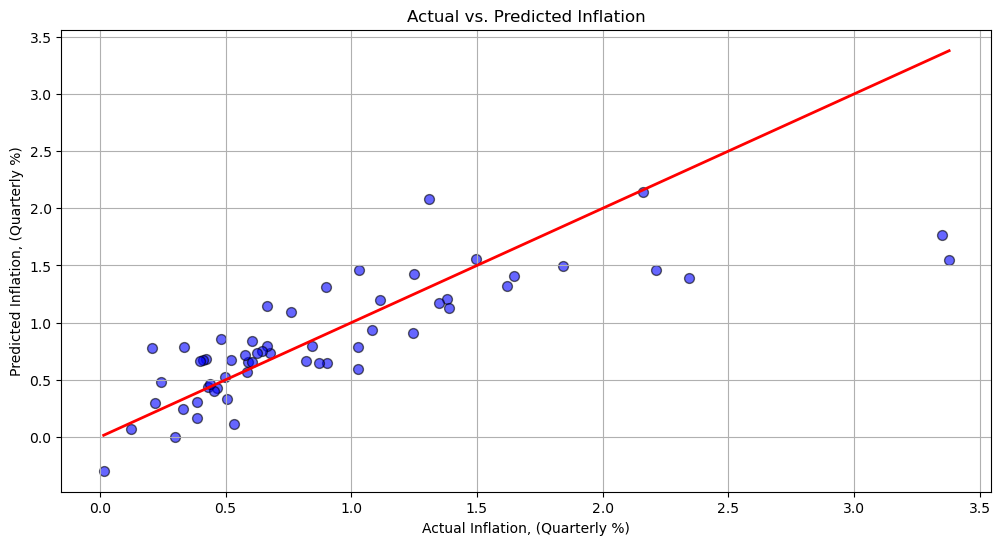

In [39]:
# 1. Actual vs. Predicted (Test Set)
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_test_pred, color='blue', edgecolor='k', s=50, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)
plt.xlabel('Actual Inflation, (Quarterly %)')
plt.ylabel('Predicted Inflation, (Quarterly %)')
plt.title('Actual vs. Predicted Inflation')
plt.grid(True)
plt.show()

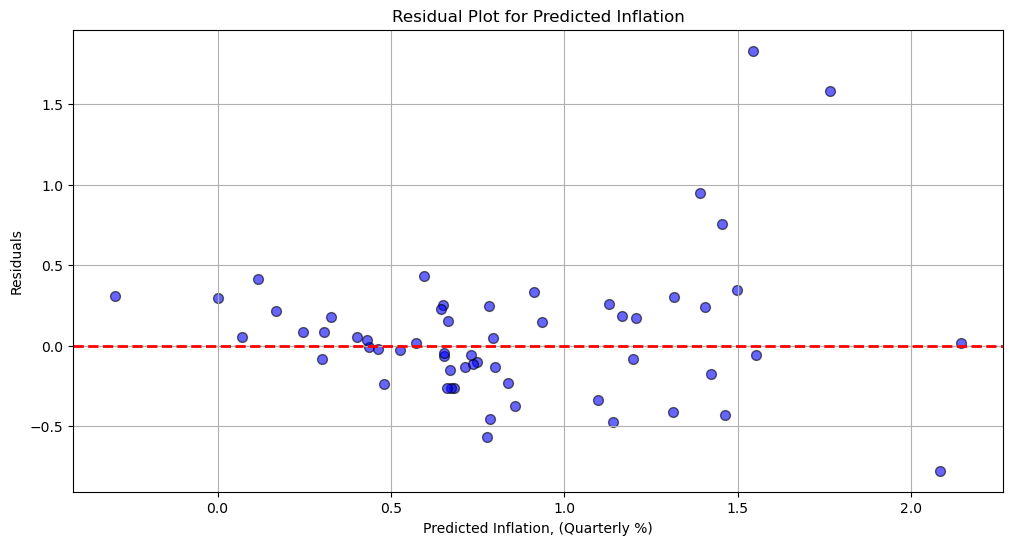

In [40]:
# Calculate residuals for the test set
residuals = y_test - y_test_pred

# Create the residual plot
plt.figure(figsize=(12, 6))
plt.scatter(y_test_pred, residuals, color='blue', edgecolor='k', s=50, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)  # Line at residual = 0
plt.xlabel('Predicted Inflation, (Quarterly %)')
plt.ylabel('Residuals')
plt.title('Residual Plot for Predicted Inflation')
plt.grid(True)
plt.show()
